In [1]:
import tensorflow as tf 
import numpy as np 
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_addons as tfa

In [2]:
(X_train, Y_train), (X_val, y_val) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [3]:
def plot_fig(X, y):
    plt.figure(figsize=(20,4))
    for index, (image, label) in enumerate(zip(X[0:5], y[0:5])):
        plt.subplot(1, 5, index + 1)
        plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
        plt.title('Training: %i\n' % int(label), fontsize = 20)

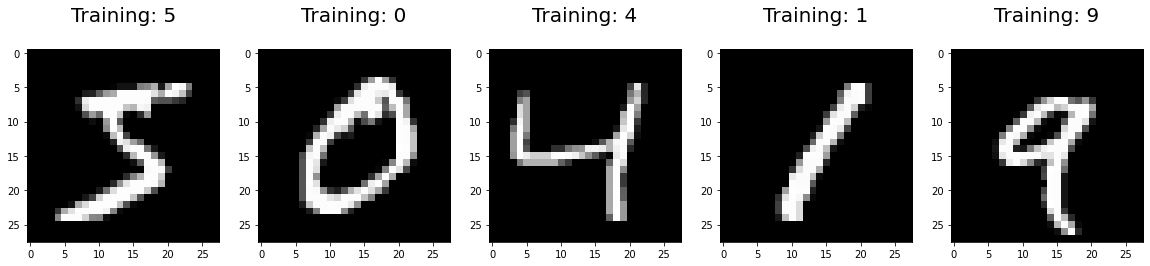

In [4]:
plot_fig(X_train, Y_train)

In [5]:
def unbalanced_dataset(X_train, Y_train):
    x_train = []
    y_train = []
    for i in range(0, len(X_train)):
        rdm1 = random.uniform(0, 1)
        rdm2 = random.uniform(0, 1)
        if (Y_train[i]%2 ==0):
            if rdm1>0.4:
                x_train.append(X_train[i])
                y_train.append(Y_train[i])
        else:
            if rdm2>0.1:
                x_train.append(X_train[i])
                y_train.append(Y_train[i])
                
    return x_train, y_train


In [6]:
x_train_ub, y_train_ub = unbalanced_dataset(X_train, Y_train)

In [7]:
def check_class_distribution(y_train):
    class_frq = {}
    for val in y_train:
        if class_frq.get(val) is not None:
            class_frq[val] = class_frq.get(val) +1
        else:
            class_frq[val] = 1
    class_frq
    
    return class_frq

In [8]:
print("Class Distribution: ", check_class_distribution(y_train_ub))

Class Distribution:  {5: 4906, 0: 3615, 1: 6106, 9: 5358, 3: 5477, 6: 3480, 2: 3567, 8: 3551, 4: 3429, 7: 5656}


In [9]:
def preprocess_data(x_train, y_train, x_val, y_val):
    """
    Return nomalized X and one-hot encoded Y-label 
    """
    # expand new axis, channel axis 
    x_train = np.expand_dims(x_train, axis=-1)
    # [optional]: we may need 3 channel (instead of 1)
    x_train = np.repeat(x_train, 3, axis=-1)
    # it's always better to normalize 
    x_train = x_train.astype('float32') / 255
    # resize the input shape , i.e. old shape: 28, new shape: 32
    x_train = tf.image.resize(x_train, [32,32]) # if we want to resize 
    
    x_val = np.expand_dims(x_val, axis=-1)
    x_val = np.repeat(x_val, 3, axis=-1)
    x_val = x_val.astype('float32') / 255
    x_val = tf.image.resize(x_val, [32,32]) # if we want to resize 
    
    # one hot 
    y_train = tf.keras.utils.to_categorical(y_train , num_classes=10)
    y_val = tf.keras.utils.to_categorical(y_val , num_classes=10)

    return x_train, y_train, x_val, y_val

In [10]:
x_train, y_train, x_val, y_val = preprocess_data(X_train, Y_train,X_val, y_val)

2021-11-15 22:40:55.648267: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-15 22:40:55.780715: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-15 22:40:55.781424: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-15 22:40:55.783813: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [11]:
x_train_ub, y_train_ub, x_val_ub, y_val_ub = preprocess_data(x_train_ub, y_train_ub, X_val, y_val)

In [12]:
class LDAMLoss():

    def __init__(self, cls_num_list, max_m=0.5, weight=None, s=30):
        super(LDAMLoss, self).__init__()
        m_list = 1.0 / np.sqrt(np.sqrt(cls_num_list)+0.000005)
        m_list = m_list * (max_m / np.max(m_list))
        m_list = tf.convert_to_tensor(m_list, dtype=tf.float32)
        self.m_list = m_list
        assert s > 0
        self.s = s
        self.weight = weight
        self.n_classes = len(cls_num_list)

    def __call__(self, target, x):
        # contrary to pytorch implemenation, our labels are already one hot encoded
        index_float = target
        #self.m_list =np.reshape(self.m_list, (10,1))
        batch_m = tf.matmul(self.m_list[None, :], tf.transpose(index_float))
        batch_m = tf.reshape(batch_m, (-1, 1))
        x_m = x - batch_m

        # if condition is true, return x_m[index], otherwise return x[index]
        index_bool = tf.cast(index_float, tf.bool)
        output = tf.where(index_bool, x_m, x)

        labels = index_float
        logits = output
        #print("labels : \n", labels, "\n logits : \n", logits)
        loss = tf.nn.softmax_cross_entropy_with_logits(
            labels=labels, logits=logits*self.s)
        return tf.reduce_mean(loss)

In [13]:
def model_with_LDAM(x_train, y_train, x_val=None, y_val=None):
    input = tf.keras.Input(shape=(32,32,3))
    efnet = tf.keras.applications.ResNet50(weights='imagenet',
                                                 include_top = False, 
                                                 input_tensor = input)
    # Now that we apply global max pooling.
    gap = tf.keras.layers.GlobalMaxPooling2D()(efnet.output)

    # Finally, we add a classification layer.
    output = tf.keras.layers.Dense(10, activation='softmax', use_bias=True)(gap)

    # bind all
    model = tf.keras.Model(efnet.input, output)
    model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=LDAMLoss([0,1,2,3,4,5,6,7,8,9]),
              metrics=['accuracy', tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),
                       tfa.metrics.F1Score(10),tf.keras.metrics.AUC()])

    model.fit(x_train, y_train, epochs=5, verbose = 2)
    

In [14]:
model_with_LDAM(x_train_ub, y_train_ub) # training on unbalanced data

94781440/94765736 [==============================] - 1s 0us/step


2021-11-15 22:41:11.150045: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5


2021-11-15 22:41:18.100737: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1411/1411 - 61s - loss: 0.6860 - accuracy: 0.9077 - precision: 0.9748 - recall: 0.3310 - f1_score: 0.9043 - auc: 0.9816
Epoch 2/5
1411/1411 - 49s - loss: 1.7959 - accuracy: 0.6246 - precision: 0.8759 - recall: 0.1226 - f1_score: 0.6232 - auc: 0.8875
Epoch 3/5
1411/1411 - 49s - loss: 0.3588 - accuracy: 0.9257 - precision: 0.9875 - recall: 0.1788 - f1_score: 0.9232 - auc: 0.9902
Epoch 4/5
1411/1411 - 49s - loss: 0.2777 - accuracy: 0.9450 - precision: 0.9892 - recall: 0.1956 - f1_score: 0.9431 - auc: 0.9936
Epoch 5/5
1411/1411 - 49s - loss: 1.1335 - accuracy: 0.8504 - precision: 0.8748 - recall: 0.1427 - f1_score: 0.8470 - auc: 0.9613


In [15]:
model_with_LDAM(x_train, y_train) # training on balance dataset (default MNIST dataset)

Epoch 1/5
1875/1875 - 71s - loss: 1.6189 - accuracy: 0.7523 - precision_1: 0.8249 - recall_1: 0.1015 - f1_score: 0.7484 - auc_1: 0.9263
Epoch 2/5
1875/1875 - 65s - loss: 0.2692 - accuracy: 0.9556 - precision_1: 0.9865 - recall_1: 0.2069 - f1_score: 0.9553 - auc_1: 0.9926
Epoch 3/5
1875/1875 - 66s - loss: 1.6723 - accuracy: 0.7943 - precision_1: 0.7731 - recall_1: 0.1155 - f1_score: 0.7907 - auc_1: 0.9375
Epoch 4/5
1875/1875 - 65s - loss: 1.6497 - accuracy: 0.8173 - precision_1: 0.7557 - recall_1: 0.1119 - f1_score: 0.8153 - auc_1: 0.9421
Epoch 5/5
1875/1875 - 65s - loss: 1.4957 - accuracy: 0.8109 - precision_1: 0.7858 - recall_1: 0.1095 - f1_score: 0.8096 - auc_1: 0.9480
